In [1]:
from Bio import SeqIO
from Bio.Seq import Seq, MutableSeq
import numpy as np; np.random.seed(1994)
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def find_string_overlapping(query, target):
    return([i for i in range(len(target)) if target[i:i+len(query)] == query])

In [3]:
def find_dinucleotide(sequence, dinucleotide):

    nucleotide_code = {
        "Y": ["T", "C"],
        "R": ["A", "G"],
        "S": ["G", "C"],
        "W": ["A", "T"],
        "M": ["A", "C"],
        "K": ["G", "T"],
        "A": ["A"],
        "G": ["G"],
        "C": ["C"],
        "T": ["T"],
        "N": ["A", "G", "C", "T"]
    }

    if not all([x in nucleotide_code for x in dinucleotide]):
        raise Exception("Some nucleotides are weird and are not in my list bro")
        
        
    # Use itertools product to get all the combinations
    l1 = nucleotide_code[dinucleotide[0]]
    l2 = nucleotide_code[dinucleotide[1]]
    combinations = [''.join(x) for x in itertools.product(l1, l2)]
    
    # find all combinations in the sequence
    l = []
    for query in combinations:
        l.append(find_string_overlapping(query, sequence))
    
    # put them all in the same list and sort
    coordinates = [y for x in l for y in x]
    coordinates.sort()
    return(coordinates)

In [4]:
def pw_distance(v1, v2, max_distance = 100):
    return([abs(i-j) for i in v1 for j in v2 if abs(i-j)<=max_distance])

In [5]:
def apply_mask(sequence, mask):

    if not type(sequence) == Seq:
        raise Exception("sequence must be a Biopython Seq object")
        
    out_seq = MutableSeq(sequence)

    for coord in mask:
        out_seq[coord:coord+2] = mask[coord]

    return(Seq(out_seq))

In [6]:
def create_rigid_mask(dinucleotide, length, start=0, distance = 15):

    nucleotide_code = {
        "Y": ["T", "C"],
        "R": ["A", "G"],
        "S": ["G", "C"],
        "W": ["A", "T"],
        "M": ["A", "C"],
        "K": ["G", "T"],
        "A": ["A"],
        "G": ["G"],
        "C": ["C"],
        "T": ["T"],
        "N": ["A", "G", "C", "T"]
    }
    
    out_dict = {}
    
    for i in range(start, length-start, distance):
        out_dict[i] = MutableSeq("NN")
        for j, b in enumerate(dinucleotide):
            out_dict[i][j] = np.random.choice(nucleotide_code[b])
    
    return out_dict

In [7]:
def plot_YY_RR(sequence):

    coord1 = find_dinucleotide(sequence, "YY")
    coord2 = find_dinucleotide(sequence, "RR")

    dist_df = pd.concat(
        [pd.DataFrame({
            "anchor": "YY",
            "dist_to": "YY",
            "distance": pw_distance(coord1, coord1)}),
        pd.DataFrame({
            "anchor": "YY",
            "dist_to": "RR",
            "distance": pw_distance(coord1, coord2)})]).reset_index(drop=True)

    sns.histplot(
        data=dist_df,
        x="distance",
        hue="dist_to",
        stat="count",
        binwidth=1,
        kde=True,
        kde_kws = {"bw_adjust": 0.4},
        element="step"
    )
    plt.xlim(0, 50)

# Read Sequences

In [8]:
aav_seqs = {entry.description: entry.seq.upper() for entry in SeqIO.parse("../sequences/aav/AAV_serotypes.periodConstructs.fasta", "fasta")}
lambda_seq_complete = aav_seqs["lambda_4.8"]
lambda_fragments = lambda_seq_complete[1941:4568]
test_seq = Seq("."*len(lambda_fragments))
len(test_seq)

2627

# Create Masks

In [9]:
YY_mask_rigid = create_rigid_mask("YY", len(test_seq))
RR_mask_rigid = create_rigid_mask("RR", len(test_seq), start=7)

In [10]:
both_masks = apply_mask(apply_mask(test_seq, YY_mask_rigid), RR_mask_rigid)
print(both_masks)

TC.....GA......TC.....AA......TT.....GA......TT.....AG......TC.....AG......TT.....GG......CC.....AA......CC.....GA......CT.....GG......TT.....GG......CC.....AA......TC.....GG......TT.....GG......CC.....GG......TC.....AG......CT.....GG......CC.....AA......CT.....AA......TT.....GA......TC.....AA......TC.....AG......CC.....AA......CC.....GA......CT.....AA......TC.....GA......CC.....GA......CT.....GG......TT.....GG......CT.....GA......TT.....AG......CC.....AG......CC.....AG......TC.....GA......CT.....AG......CT.....GG......CT.....GA......TT.....AA......TT.....GG......TC.....AA......TC.....AA......TT.....AA......CC.....GG......TC.....GG......TC.....AA......TT.....AG......TC.....AA......TT.....GG......CT.....GA......TC.....AG......TC.....GG......CT.....AG......TC.....AA......CC.....GA......CC.....AG......CC.....AG......CC.....GA......CC.....GG......TT.....GA......TC.....GG......CT.....GG......CT.....GA......CC.....AG......TC.....GA......TC.....GG......TT.....GG......TC.....AA......TC.....GA.

In [11]:
1 - both_masks.count(".") / len(both_masks)

0.26722497145032353

Here only 27% of the sequence is changed

## Apply to lambda

In [12]:
masked_lambda = apply_mask(apply_mask(lambda_fragments, YY_mask_rigid), RR_mask_rigid)
print(masked_lambda)

TCGTATCGATGAGAATCACGACAACACGTATTCCATCGACGCCGTTTAGCATAGGCCGGATCAAGAGAGCATCGTTTATAACGGGGCGCACCTTGACAACGAACACCGTGGCGAGGTGAACTGTGTCGGGCCGCCTTCGGTGGGGCACCTCCCCGCAAAAGTCACTCCAGACGGCGGGGATTATCAGGGGCTGGCCCGATGGGGCACACCTCAGGTGAGGAAGGGCTTGAGTGGCCTGCTCCGTCTGAACGTAACCTCGGACAACGGCAGTTAGCGGGAGGTCAGTCCGGCCAAGACGACTCAAACCAGATACCGCCTCACGAAACTGGCCCTGGGGGACTACAGCTTGACAAACCGGGCTCTAAATGAGTGGGGCCAGCAGGACGATCCCTCGTCGGGATCGTTTTGGATTGGCGCACCCTCAGCAGAGTCGAGTTTTGAGAGGACGCCCCGCTATAGTCAGATCCCCGCCAGGCCGCATCTTGCCGATTATGACTCGACGAGACAGTTCTAGTTCGGGTTCTCCTAAAAGGAGATTGCTTATATCAAACAGGTTTAAACCGGCACGCGTCATCTTAATACGGCTCTGTACAAGATAGCTTCCAGTAACAATATCCAACCGGGCCATGATCATTACGGTTATATTCGCAGTAAGAACACTTTTGGCAGATCGGCTCTCGTGAAGGCCGTTTGTCGGGGGAGCGACTATGCGGAAGGTTATCTGGATAGTTTCAATCGCAAGGGAACCGACTCCCATAGCGGCAATCAGCTGAAGGAAAACCTCGAGGAGACGGACCATAACAGCAGCAGCCTGGAGAGGTTTTCCCAAGAGGAGAAGGACCCCAGTGGTAAGTGTTATGCCGAGTGGGCTCTCAAAGGTGAGCACTCCAAAGGCGGCAACTATTATGACGCGGGCCTTGGCAGCAGCATTCAGGACGAGGAGGATCGCAAAGGGAGCCATTTTCTGGGTGCCGCTCATCGTAACGCATTTCTTGACGAG

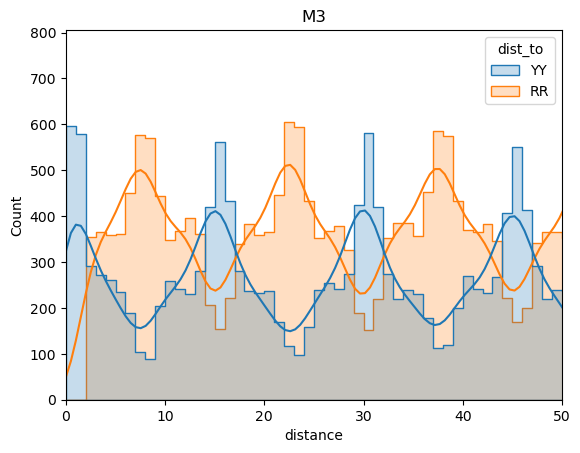

In [17]:
plot_YY_RR(masked_lambda)
plt.title("M3")
plt.savefig("../periodify/mask/raw_sequences/M3_YY.histogram.png", dpi=100)

In [14]:
with open("../periodify/mask/raw_sequences/m3_lambda.fasta", "w") as out:
    out.write(">m3_lambda\n")
    out.write(str(masked_lambda) + "\n")